Importation des librairies

In [1]:
import numpy as np
from numpy.fft import fft2,ifft2
from skimage import io as skio
import matplotlib.pyplot as plt
import tempfile
import IPython
from skimage.transform import rescale
import cv2
import pandas as pd


Fonction pour visualiser une image

In [2]:
def viewimage(im, normalize=True,vmin=0,vmax=255,z=2,order=0,titre='',displayfilename=False):
    if im.shape[2]==1:
        im = np.squeeze(im)
        z = 1
    imin= np.array(im).astype(np.float32)
    channel_axis = 2 if len(im.shape)>2 else None
    imin = rescale(imin, z, order=order, multichannel=True)
    if normalize:
        if vmin is None:
            vmin = imin.min()
        if vmax is None:
            vmax = imin.max()
        imin-=vmin
        if np.abs(vmax-vmin)>1e-10:
            imin = (imin.clip(vmin,vmax)-vmin)/(vmax-vmin)
        else:
            imin = vmin
    else:
        imin=imin.clip(0,255)/255 
    imin=(imin*255).astype(np.uint8)
    filename=tempfile.mktemp(titre+'.png')
    if displayfilename:
        print (filename)
    plt.imsave(filename, imin, cmap='gray')
    IPython.display.display(IPython.display.Image(filename))

Fonctions pour dessiner un masque à la souris

In [3]:
drawing = False
ix, iy = -1, -1
mask = None
image_display = None

def draw_mask(event, x, y, flags, param):
    global drawing, ix, iy, mask, image_display

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ix, iy = x, y

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            cv2.line(mask, (ix, iy), (x, y), 0, thickness=5)
            cv2.line(image_display, (ix, iy), (x, y), (0, 0, 255), thickness=5)
            ix, iy = x, y

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        cv2.line(mask, (ix, iy), (x, y), 0, thickness=5)
        cv2.line(image_display, (ix, iy), (x, y), (0, 0, 255), thickness=5)

def create_mask(image_path,C):
    global mask, image_display

    image = cv2.imread(image_path)
    if C==1:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_display = image.copy()
    mask = np.ones(image.shape[:2], dtype=np.uint8) * 255

    cv2.namedWindow('Image')
    cv2.setMouseCallback('Image', draw_mask)

    print("Appuyez sur 'Entrée' lorsque vous avez terminé le masque")

    while True:
        cv2.imshow('Image', image_display)
        key = cv2.waitKey(1) & 0xFF

        if key == 13:
            cv2.imwrite('mask.png', mask)
            break

    cv2.destroyAllWindows()
    mask = (mask == 255).astype(np.uint8)
    return np.atleast_3d(mask)

Implémentation de la méthode oracle pour synthétiser une microtexture

In [4]:
def oracle(im,k):
    M,N,C = im.shape
    m = np.mean(im,axis=(0,1))
    tu = (im-m)/np.sqrt(M*N)
    tu_padded = np.zeros((k*M,k*N,C), dtype='float')
    tu_padded[:M,:N,:] = np.copy(tu)

    im_estimation = np.zeros_like(tu_padded, dtype='float')
    W = np.random.normal(0, 1, (tu_padded.shape[:2])).astype(np.float32)

    for c in range(C):
        im_estimation[:, :, c] = m[c] + np.real(ifft2(fft2(np.squeeze(tu_padded[:,:,c]))*fft2(W)))
    
    return im_estimation

Fonction pour comparer les caractéristiques statistiques de 2 images dans un tableau

In [5]:
pd.set_option("display.float_format", lambda x: "%.2f" % x)

def compute_stats(image):
    stats = {}
    for channel, color in enumerate(["Red", "Green", "Blue"]):
        flattened = image[..., channel].flatten()
        stats[color] = {
            "Mean": np.mean(flattened),
            "1st Quartile": np.percentile(flattened, 25),
            "3rd Quartile": np.percentile(flattened, 75)
        }
    return stats

def compare_image_statistics(image1, image2):
    stats1 = compute_stats(image1)
    stats2 = compute_stats(image2)

    rows = []
    for color in ["Red", "Green", "Blue"]:
        row = {
            "Channel": color,
            "Image (Mean, Q1, Q3)": (
                round(stats1[color]["Mean"], 2),
                round(stats1[color]["1st Quartile"], 2),
                round(stats1[color]["3rd Quartile"], 2),
            ),
            "Estimation (Mean, Q1, Q3)": (
                round(stats2[color]["Mean"], 2),
                round(stats2[color]["1st Quartile"], 2),
                round(stats2[color]["3rd Quartile"], 2),
            ),
        }
        rows.append(row)

    comparison_table = pd.DataFrame(rows)

    return comparison_table


Tests de la méthode Oracle et comparaison des statistiques de la microtexture et sa synthèse

microtexture originale :


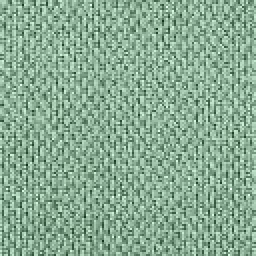

microtexture synthétisée :


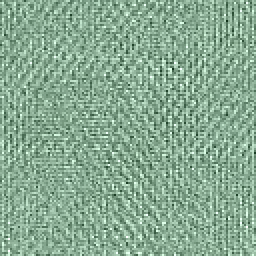

,Channel,"Image (Mean, Q1, Q3)","Estimation (Mean, Q1, Q3)"
0,Red,"(137.12, 113.0, 164.0)","(137.12, 114.41, 159.59)"
1,Green,"(171.15, 147.0, 198.25)","(171.15, 148.48, 193.64)"
2,Blue,"(147.02, 123.0, 174.0)","(147.02, 124.4, 169.44)"


In [6]:
im=skio.imread('microtextures/microtexture4.jpg')
im = np.atleast_3d(im)
print('microtexture originale :')
viewimage(im)
im_estimation = oracle(im,1)
print('microtexture synthétisée :')
viewimage(im_estimation)
compare_image_statistics(im,im_estimation)

Fonctions pour créer des masques carrés et des bordures

In [7]:
def square_mask(M,N,t):
    masked_im = np.ones((M,N))
    masked_im[M//2-t//2:M//2+t//2,N//2-t//2:N//2+t//2] = 0
    return np.atleast_3d(masked_im).astype(np.uint8)

def inverse_mask(mask):
    return (mask + 1) % 2


def get_cst_ker(l):
    return np.ones((l,l))/l**2

def filtre_lineaire(im,mask):
    (y,x)=im.shape
    (ym,xm)=mask.shape
    mm=np.zeros((y,x))
    mm[:ym,:xm]=mask
    fout=(fft2(im)*fft2(mm))
    mm[:ym,:xm]=0
    y2=int(np.round(ym/2-0.5))
    x2=int(np.round(xm/2-0.5))
    mm[y2,x2]=1
    out=np.real(ifft2(fout*np.conj(fft2(mm))))
    return out


def border_mask(mask,l):
    bord = filtre_lineaire(np.squeeze(inverse_mask(mask)),get_cst_ker(l))*np.squeeze(mask)
    bord[bord>0.001] = 1
    bord[bord<=0.001] = 0
    return np.atleast_3d(bord).astype(np.uint8)

Tests des fonctions de masques

image originale


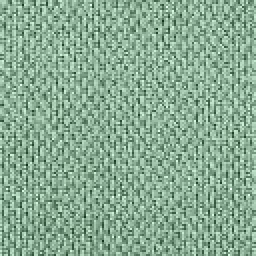

image masquée


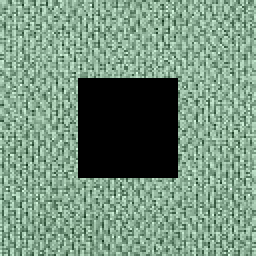

image sur la bordure du masque


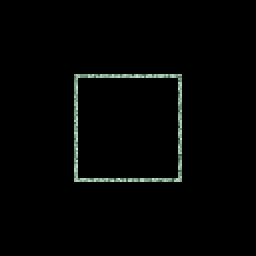

Nombre pixels bordure : 416


In [8]:
print('image originale')
viewimage(im)
mask = square_mask(im.shape[0],im.shape[1],50)
print('image masquée')
viewimage(im*mask)
border = border_mask(mask,5)
print('image sur la bordure du masque')
viewimage(im*border)
print(f'Nombre pixels bordure : {np.count_nonzero(border)}')

Fonctions pour calculer l'autocovariance et synthétiser une microtexture masquée avec la méthode de l'ADSN

In [9]:
def compute_autocovariance(tv):
    M, N, C = tv.shape

    cv = np.zeros((M, N, C, C), dtype='float')
    fft_tv = fft2(tv, axes=(0, 1))
    for i in range(C):
        for j in range(i, C):
            cv_temp = np.real(ifft2(fft_tv[:, :, i] * np.conj(fft_tv[:, :, j])))
            cv[:, :, i, j] = cv_temp
            cv[:, :, j, i] = cv_temp
            
    return cv

def adsn(im,k,mask):

    M,N,C = im.shape
    card_w = np.count_nonzero(mask)
    m = np.sum(im, axis=(0, 1))/card_w
    tv = (im-m)*mask/np.sqrt(card_w)

    cv = compute_autocovariance(tv)

    tv_padded = np.zeros((k*M,k*N,C), dtype='float')
    tv_padded[:M,:N,:] = np.copy(tv)

    im_estimation = np.zeros_like(tv_padded, dtype='float')
    W = np.random.normal(0, 1, (tv_padded.shape[:2])).astype(np.float32)

    for c in range(C):
        im_estimation[:, :, c] = np.real(ifft2(fft2(np.squeeze(tv_padded[:,:,c]))*fft2(W)))
    
    return im_estimation,cv

Tests de la méthode ADSN

image masquée :


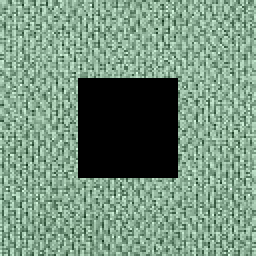

synthèse ADSN :


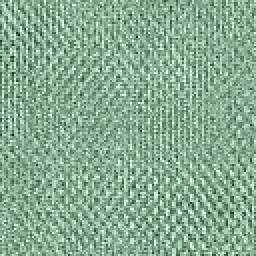

image inpaintée :


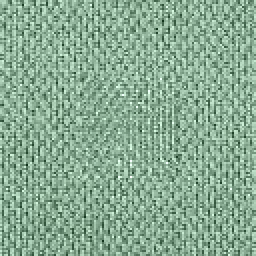

In [10]:
mask = square_mask(im.shape[0],im.shape[1],50)
im_masked = im*mask
print('image masquée :')
viewimage(im_masked)
im_estimation, cv = adsn(im_masked,2,mask)
im_estimation = np.sum(im_masked, axis=(0, 1))/np.count_nonzero(mask) + im_estimation[:im.shape[0],:im.shape[1],:]
print('synthèse ADSN :')
viewimage(im_estimation)
print('image inpaintée :')
viewimage(im_masked + im_estimation*inverse_mask(mask))

Fonction pour visualiser l'autocovariance intercanal entre les canaux a et b

In [11]:
def visualisation_cv_intercanal(cv,a,b):
    plt.imshow(cv[:,:,a,b], cmap="viridis")
    plt.colorbar()
    plt.title(f'Autocovariance (cv) intercanaux :{a,b}')
    plt.show()
    return

Plot d'une covariance intercanal

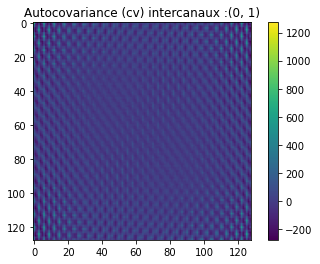

In [12]:
visualisation_cv_intercanal(cv,0,1)

Fonctions pour vérifier le caractère symétrique et défini positif d'une matrice de covariance gamma

In [13]:
def verify_symmetry(gamma):
    size = gamma.shape[0]
    for i in range(size):
        for j in range(size):
            if not np.allclose(gamma[i, j], gamma[j, i], atol=1e-10):
                print(f"Asymétrie détectée entre les blocs ({i}, {j}) et ({j}, {i})")
                return False
        return True
    
    
def verify_positive_definite(gamma):
    eigenvalues = np.linalg.eigvals(gamma)
    print(np.min(eigenvalues))
    return np.all(eigenvalues > 0)


Fonctions pour passer d'une image de omega à C et inversement

In [14]:
def linearize_image_on_C(image, border):
    M, N, C = image.shape

    indices = np.indices((M, N)).reshape(2, -1).T
    
    border_flat = border.reshape(-1)
    
    im_flat = image.reshape(-1, C)
    

    one_indices = np.where(border_flat == 1)[0]
    
    im_reordered = im_flat[one_indices]
    indices_reordered = indices[one_indices]
    
    return im_reordered, indices_reordered


def padding_C_to_omega(psi_C,order_C,shape):
    psi_padded = np.zeros(shape)
    for value, (i, j) in zip(psi_C, order_C):
        psi_padded[i, j] = value
    return psi_padded

Fonction pour construire la matrice de covariance sur un contour

In [15]:
def build_covariance_matrix_on_C(cv,order_C):
    _, _, *C = cv.shape
    size = order_C.shape[0]
    
    gamma = np.zeros((size, size, *C))
    for m in range(size):
        for n in range(size):
            gamma[m,n] = cv[order_C[m][0]-order_C[n][0],order_C[m][1]-order_C[n][1]]
            
    return gamma

Fonction pour calculer psi en faisant le produit matriciel du pseudo inverse de la matrice de covariance sur C avec phi

In [16]:
def compute_psi_C(gamma_C_C, phi_C):
    p, _, d, _ = gamma_C_C.shape
        
    gamma_C_C_flat = gamma_C_C.transpose(0, 2, 1, 3).reshape(p * d, p * d)
    
    phi_C_flat = phi_C.reshape(p * d)
    psi_flat = np.linalg.lstsq(gamma_C_C_flat, phi_C_flat,rcond=None)[0]
    psi = psi_flat.reshape(p, d)

    #print(verify_symmetry(gamma_C_C_flat))
    #print(verify_positive_definite(gamma_C_C_flat))
        
    return psi

Fonction pour convoluer une matrice de Omega dans R^d avec l'autocovariance de Omega dans R^(d*d)

In [17]:
def convolve_fft(a,b):
    return np.real(ifft2(fft2(a, axes=(0, 1))*fft2(b, axes=(0, 1)), axes=(0, 1)))

def convolve_cv(PSI, cv):
    C = PSI.shape[2]

    result = np.zeros_like(PSI, dtype='float')
    for i in range(C):
        for j in range(C):
            result[..., i] += convolve_fft(PSI[..., j],cv[..., j, i])

    return result

Fonction pour synthétiser une texture ADSN puis la conditionner sur la bordure et inpainter l'image masquée

In [18]:
def conditional_adsn(im,k,mask,border):
    F,cv = adsn(im,k,mask)
    F = F[:im.shape[0],:im.shape[1],:]
    card_w = np.count_nonzero(mask)
    m = np.sum(im, axis=(0, 1))/card_w

    im_centree_C, order_C = linearize_image_on_C(im-m,border)
    F_C,_ = linearize_image_on_C(F,border)

    gamma_C_C = build_covariance_matrix_on_C(cv,order_C)


    psi = compute_psi_C(gamma_C_C,im_centree_C - F_C)

    psi_padded = padding_C_to_omega(psi,order_C,im.shape)

    kriging_innovation_component = convolve_cv(psi_padded, cv)


    conditionnal_synthesis = m + F + kriging_innovation_component
    return np.squeeze(im) + np.squeeze(conditionnal_synthesis*inverse_mask(mask)),conditionnal_synthesis

Tests d'inpainting et calcul de la MSE entre la microtexture et sa synthèse conditionnée sur la bordure

Appuyez sur 'Entrée' lorsque vous avez terminé le masque
masked image :


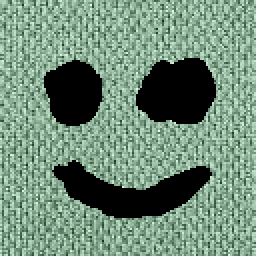

inpainted image :


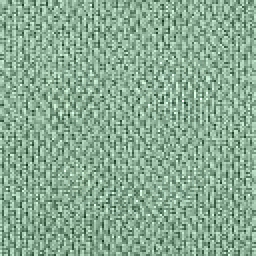

MSE entre l'image originale et la synthèse conditionnée sur le contour : 1.138482530928204e-22


In [19]:
image_path = 'microtextures/microtexture4.jpg'
im=skio.imread(image_path)
im = np.atleast_3d(im)
#mask = square_mask(im.shape[0],im.shape[1],70)
mask = create_mask(image_path,im.shape[2])
border = border_mask(mask,5)
print('masked image :')
viewimage(im*mask)
inpainted, conditionnal_synthesis = conditional_adsn(im*mask,1,mask,border)
print('inpainted image :')
viewimage(np.atleast_3d(inpainted))
im_C, _ = linearize_image_on_C(im,border)
cond_C, _ = linearize_image_on_C(conditionnal_synthesis,border)
print("MSE entre l'image originale et la synthèse conditionnée sur le contour :",np.mean((im_C-cond_C)**2))